### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#294B8E; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #294B8E">Обнаружение каверов музыкальных треков</p>

<a id="1.2"></a>
<div style="padding:20px;
            color:white;
            margin:10;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:5px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700"><span style='color:#CDA63A'>|</span> Содержание</div>

<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание данных</a></span></li>
    <li><span><a href="#Загрузка-библиотек" data-toc-modified-id="Загрузка-библиотек-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка библиотек</a></span></li>
    <li><span><a href="#EDA" data-toc-modified-id="EDA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>EDA</a></span></li>
    <li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Предобработка данных</a></span></li>
    <li><span><a href="#Подготовим-выборки-для-обучения-моделей" data-toc-modified-id="Подготовим-выборки-для-обучения-моделей-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Подготовим выборки для обучения моделей</a></span></li>
    <li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Обучение модели</a></span></li>
       <li><span><a href="#Проверка-на-тестовых-данных" data-toc-modified-id="Проверка-на-тестовых-данных-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Проверка на тестовых данных</a></span></li>
    <li><span><a href="#Вывод" data-toc-modified-id="Вывод-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Вывод</a></span></li>

<a id="Описание-данных"></a>
<div style="padding:20px;
            color:white;
            margin:10;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:5px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700"><span style='color:#CDA63A'>|</span> Описание данных</div>

## covers
<ul>
<li>track_id - уникальный идентификатор трека;</li>
<li>track_remake_type - метка, присвоенная редакторами. Может принимать значения ORIGINAL и COVER;</li>
<li>original_track_id - уникальный идентификатор исходного трека.</li>
</ul>

## lyrics
<ul>
<li>track_id - уникальный идентификатор трека;</li>
<li>lyricId - уникальный идентификатор текста;</li>
<li>text - текст трека.</li>
</ul>

## meta
<ul>
<li>track_id - уникальный идентификатор трека;</li>
<li>dttm - первая дата появления информации о треке;</li>
<li>title - название трека;</li>
<li>language - язык исполнения;
<li>isrc - международный уникальный идентификатор трека;</li>
<li>genres - жанры;</li>
<li>duration - длительность трека;</li>
</ul>

<div class="alert alert-block alert-info" style="background-color:#FFFAF0;
                                                 color:black;
                                                 border-color:#DEB887;
                                                 border-radius:5px;
                                                 width:50%;
                                                 margin: auto;
                                                 text-align: left;">


Обнаружение треков каверов - важная продуктовая задача, которая может значительно улучшить качество рекомендаций музыкального сервиса и повысить счастье наших пользователей. 

</div>

<div class="alert alert-block alert-info" style="background-color:#FFFAF0;
                                                 color:black;
                                                 border-color:#DEB887;
                                                 border-radius:5px;
                                                 width:50%;
                                                 margin: auto;
                                                 text-align: left;">
<h1>Ход исполнения</h1>
<ul>
<li>Изучим и предобработаем данные.</li> 
<li>Разделим исходные данные на обучающую и тестовую выборки.</li> 
<li>Проведем масштабирование и кодировку признаков.</li> 
<li>Исследуем качество модели, меняя гиперпараметры. Кратко опишем выводы исследования.</li> 
</ul>

<a id="Загрузка-библиотек"></a>
<div style="padding:20px;
            color:white;
            margin:10;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:5px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700"><span style='color:#CDA63A'>|</span> Загрузка библиотек</div>

In [1]:
import re
import torch
import json
import pandas as pd
import numpy as np
import seaborn as sns
import spacy
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from catboost import CatBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from scipy.stats import pointbiserialr, chi2_contingency
from sentence_transformers import SentenceTransformer
import transformers
from transformers import BertModel, BertForMaskedLM
from transformers import BertTokenizer
from tqdm import notebook
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

import warnings
warnings.filterwarnings("ignore")

<a id="EDA"></a>
<div style="padding:20px;
            color:white;
            margin:10;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:5px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700"><span style='color:#CDA63A'>|</span> EDA</div>

In [2]:
covers = pd.read_json('covers.json', lines=True)

In [3]:
meta = pd.read_json('meta.json', lines=True, convert_dates=['dttm'])

In [4]:
lyrics = pd.read_json('lyrics.json', lines=True)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">Изучим наши датафреймы.

In [5]:
covers.head(10)

,original_track_id,track_id,track_remake_type
0,eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL
1,fe7ee8fc1959cc7214fa21c4840dff0a,fe7ee8fc1959cc7214fa21c4840dff0a,ORIGINAL
2,cd89fef7ffdd490db800357f47722b20,cd89fef7ffdd490db800357f47722b20,ORIGINAL
3,995665640dc319973d3173a74a03860c,995665640dc319973d3173a74a03860c,ORIGINAL
4,None,d6288499d0083cc34e60a077b7c4b3e1,COVER
5,None,4da9d7b6d119db4d2d564a2197798380,COVER
6,None,2bf283c05b601f21364d052ca0ec798d,COVER
7,None,5eb13cb69b6e20dd7a42030f5936a9dc,COVER
8,None,109f91266ef89cc3690079b28abfe9a3,COVER
9,76c538125fc5c9ec6ad1d05650a57de5,76c538125fc5c9ec6ad1d05650a57de5,ORIGINAL


In [6]:
covers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71597 entries, 0 to 71596
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_track_id  4821 non-null   object
 1   track_id           71597 non-null  object
 2   track_remake_type  71597 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB


In [7]:
covers.describe()

,original_track_id,track_id,track_remake_type
count,4821,71597,71597
unique,4468,71597,2
top,f3e5e9db509f9b6f6d93b9c38e4e1324,eeb69a3cb92300456b6a5f4162093851,COVER
freq,38,1,67304


In [8]:
covers.duplicated().sum()

0

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">Посмотрим на дисбаланс классов.

In [9]:
covers.track_remake_type.value_counts()

track_remake_type
COVER       67304
ORIGINAL     4293
Name: count, dtype: int64

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">Посмотрим на кол-во записей, где original_track_id и track_id совпадают.

In [10]:
len(covers[covers['original_track_id'] == covers['track_id']])

4293

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">Кол-во записей совпадают, перейдем к другим датасетам.

In [11]:
meta.head(10)

,track_id,dttm,title,language,isrc,genres,duration
0,c3b9d6a354ca008aa4518329aaa21380,2021-12-16 21:00:00,Happy New Year,EN,RUB422103970,[DANCE],161120.0
1,c57e3d13bbbf5322584a7e92e6f1f7ff,2021-11-24 14:00:33,Bad Habits,EN,QZN882178276,[ELECTRONICS],362260.0
2,955f2aafe8717908c140bf122ba4172d,2021-11-24 15:37:03,Por Esa Loca Vanidad,None,QZNJZ2122549,"[FOLK, LATINFOLK]",260000.0
3,fae5a077c9956045955dde02143bd8ff,2021-11-24 15:37:03,Mil Lagrimas,None,QZNJZ2166033,"[FOLK, LATINFOLK]",190000.0
4,6bede082154d34fc18d9a6744bc95bf5,2021-11-24 15:37:03,Sexo Humo y Alcohol,None,QZNJZ2122551,"[FOLK, LATINFOLK]",203000.0
5,551331ee1444de6658e71933eb7f57a2,2021-11-24 15:37:03,La Ultima Vez,None,QZNJZ2166034,"[FOLK, LATINFOLK]",173000.0
6,2be8bb01bb1aeef0908524dc11935a88,2021-11-24 15:37:03,Homenaje a Pastor de los Santos,None,QZNJZ2122553,"[FOLK, LATINFOLK]",192100.0
7,3883d1add3ff8b60e77548a64df7c892,2021-11-24 15:37:03,Los Marginales,None,QZNJZ2122554,"[FOLK, LATINFOLK]",311500.0
8,59aa886979699aa7e4e2a8aed43bfe03,2021-11-24 15:37:03,Cuenta Conmigo,None,QZNJZ2122555,"[FOLK, LATINFOLK]",250000.0
9,2a38992b7769963937246288ad89b44c,2021-11-24 15:37:03,Ahora Juego Yo,None,QZNJZ2122556,"[FOLK, LATINFOLK]",156000.0


In [12]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71769 entries, 0 to 71768
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   track_id  71768 non-null  object        
 1   dttm      71768 non-null  datetime64[ns]
 2   title     71768 non-null  object        
 3   language  21969 non-null  object        
 4   isrc      71455 non-null  object        
 5   genres    71768 non-null  object        
 6   duration  71768 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 3.8+ MB


In [13]:
meta.describe(include='all')

,track_id,dttm,title,language,isrc,genres,duration
count,71768,71768,71768,21969,71455,71768,7.176800e+04
unique,71768,NaN,45462,85,71283,232,NaN
top,c3b9d6a354ca008aa4518329aaa21380,NaN,Morena,EN,USTCF1018560,"[FOLK, LATINFOLK]",NaN
freq,1,NaN,81,15322,3,18391,NaN
mean,NaN,2020-03-15 15:43:11.983502080,NaN,NaN,NaN,NaN,2.049187e+05
min,NaN,2009-08-10 17:32:06,NaN,NaN,NaN,NaN,0.000000e+00
25%,NaN,2019-10-03 22:18:39.500000,NaN,NaN,NaN,NaN,1.613700e+05
50%,NaN,2021-05-07 16:32:40,NaN,NaN,NaN,NaN,1.993950e+05
75%,NaN,2021-11-16 08:14:16,NaN,NaN,NaN,NaN,2.390700e+05
max,NaN,2023-10-18 21:00:00,NaN,NaN,NaN,NaN,5.487300e+06


In [14]:
meta_exploded = meta.explode("genres")
meta_exploded.duplicated().sum()

0

In [15]:
lyrics.head(10)

,lyricId,text,track_id
0,a951f9504e89759e9d23039b7b17ec14,"Живу сейчас обломами, обломками не той любви\n...",1c4b1230f937e4c548ff732523214dcd
1,0c749bc3f01eb8e6cf986fa14ccfc585,Tell me your fable\nA fable\nTell me your fabl...,0faea89b0d7d6235b5b74def72511bd8
2,e2c8830fbc86e5964478243099eec23a,You're ashamed about all your fears and doubts...,9c6dc41d5ccd9968d07f055da5d8f741
3,e2c8830fbc86e5964478243099eec23a,You're ashamed about all your fears and doubts...,bfd04a73e9cffdf0e282c92219a86ea1
4,7624653ca8522ba93470843c74961b7d,"You showed him all the best of you,\nBut I'm a...",8d70930d09cd239c948408d1317d8659
5,7624653ca8522ba93470843c74961b7d,"You showed him all the best of you,\nBut I'm a...",b12ecdeac6ac42e1ecac96f9f15b1159
6,aaf5c8771a94127de56c08623393434a,You lost her\nAnd now you're wishing you could...,8ef2d56d4dea12988133f6d933401733
7,aaf5c8771a94127de56c08623393434a,You lost her\nAnd now you're wishing you could...,4f41809cdbbb3d3dc99491d1273e7519
8,28d69bf999a2d26c5a6365b71d07a706,If you go now\nPlease leave the light on\nJust...,c8658fc634c181f05c882e1919e157df
9,b6b9656527783d76fcfa0fad73625f36,Justo ayer me di cuenta\nQue solo es cuestión ...,682f310c802690104b3a633b6557bac2


In [16]:
lyrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11414 entries, 0 to 11413
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   lyricId   11414 non-null  object
 1   text      11414 non-null  object
 2   track_id  11414 non-null  object
dtypes: object(3)
memory usage: 267.6+ KB


In [17]:
lyrics.describe()

,lyricId,text,track_id
count,11414,11414,11414
unique,10915,10644,10277
top,28fbafaf626c497d0d4d933b4f0d3f5b,Twenty-five years and my life is still\nI'm tr...,b891000882f4a612190142861b5c038b
freq,9,15,24


In [18]:
lyrics.duplicated().sum()

0

In [19]:
duplicated_track_id = lyrics[lyrics.duplicated(['track_id', 'text'])]
duplicated_track_id.info()

<class 'pandas.core.frame.DataFrame'>
Index: 264 entries, 848 to 11412
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   lyricId   264 non-null    object
 1   text      264 non-null    object
 2   track_id  264 non-null    object
dtypes: object(3)
memory usage: 8.2+ KB


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">Мы видим, что у нас много дубликатов по столбцам 'track_id' и 'text', избавимся от них.

In [20]:
lyrics.drop_duplicates(subset=['track_id', 'text'], inplace=True)

In [21]:
lyrics.describe()

,lyricId,text,track_id
count,11150,11150,11150
unique,10688,10644,10277
top,6fe05ce48761f833737487cd7a499cd3,"A and X, El Orfanato\nDanza Kuduro\nLucenzo El...",adc126c946551da4e1784e716b77992e
freq,9,11,10


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">Теперь посмотрим на кол-во дубликатов по столбцу 'track_id', затем удалим и их тоже.

In [22]:
duplicated_track_id = lyrics[lyrics.duplicated(['track_id'])]
duplicated_track_id.info()

<class 'pandas.core.frame.DataFrame'>
Index: 873 entries, 263 to 11411
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   lyricId   873 non-null    object
 1   text      873 non-null    object
 2   track_id  873 non-null    object
dtypes: object(3)
memory usage: 27.3+ KB


In [23]:
lyrics.drop_duplicates(subset=['track_id'], inplace=True)

In [24]:
lyrics.describe()

,lyricId,text,track_id
count,10277,10277,10277
unique,9891,9852,10277
top,6fe05ce48761f833737487cd7a499cd3,"A and X, El Orfanato\nDanza Kuduro\nLucenzo El...",1c4b1230f937e4c548ff732523214dcd
freq,9,9,1


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">Объединим наши таблицы.

In [25]:
df = meta.merge(covers, on='track_id', how='left')

In [26]:
df = df.merge(lyrics, on='track_id', how='left')

In [27]:
df.head(20)

,track_id,dttm,title,language,isrc,genres,duration,original_track_id,track_remake_type,lyricId,text
0,c3b9d6a354ca008aa4518329aaa21380,2021-12-16 21:00:00,Happy New Year,EN,RUB422103970,[DANCE],161120.0,None,COVER,36777cce0740d1e3d37a5a221c71d859,No more champagne\nAnd the fireworks are throu...
1,c57e3d13bbbf5322584a7e92e6f1f7ff,2021-11-24 14:00:33,Bad Habits,EN,QZN882178276,[ELECTRONICS],362260.0,None,COVER,8284927611c6a6fc49ff1ce7b3a88314,"Ooh-ooh, ooh, ooh\n\nEvery time you come aroun..."
2,955f2aafe8717908c140bf122ba4172d,2021-11-24 15:37:03,Por Esa Loca Vanidad,None,QZNJZ2122549,"[FOLK, LATINFOLK]",260000.0,None,COVER,NaN,NaN
3,fae5a077c9956045955dde02143bd8ff,2021-11-24 15:37:03,Mil Lagrimas,None,QZNJZ2166033,"[FOLK, LATINFOLK]",190000.0,None,COVER,NaN,NaN
4,6bede082154d34fc18d9a6744bc95bf5,2021-11-24 15:37:03,Sexo Humo y Alcohol,None,QZNJZ2122551,"[FOLK, LATINFOLK]",203000.0,None,COVER,NaN,NaN
5,551331ee1444de6658e71933eb7f57a2,2021-11-24 15:37:03,La Ultima Vez,None,QZNJZ2166034,"[FOLK, LATINFOLK]",173000.0,None,COVER,NaN,NaN
6,2be8bb01bb1aeef0908524dc11935a88,2021-11-24 15:37:03,Homenaje a Pastor de los Santos,None,QZNJZ2122553,"[FOLK, LATINFOLK]",192100.0,None,COVER,NaN,NaN
7,3883d1add3ff8b60e77548a64df7c892,2021-11-24 15:37:03,Los Marginales,None,QZNJZ2122554,"[FOLK, LATINFOLK]",311500.0,None,COVER,NaN,NaN
8,59aa886979699aa7e4e2a8aed43bfe03,2021-11-24 15:37:03,Cuenta Conmigo,None,QZNJZ2122555,"[FOLK, LATINFOLK]",250000.0,None,COVER,NaN,NaN
9,2a38992b7769963937246288ad89b44c,2021-11-24 15:37:03,Ahora Juego Yo,None,QZNJZ2122556,"[FOLK, LATINFOLK]",156000.0,None,COVER,NaN,NaN


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71769 entries, 0 to 71768
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   track_id           71768 non-null  object        
 1   dttm               71768 non-null  datetime64[ns]
 2   title              71768 non-null  object        
 3   language           21969 non-null  object        
 4   isrc               71455 non-null  object        
 5   genres             71768 non-null  object        
 6   duration           71768 non-null  float64       
 7   original_track_id  4821 non-null   object        
 8   track_remake_type  71597 non-null  object        
 9   lyricId            10277 non-null  object        
 10  text               10277 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(9)
memory usage: 6.0+ MB


In [29]:
df.describe(include='all')

,track_id,dttm,title,language,isrc,genres,duration,original_track_id,track_remake_type,lyricId,text
count,71768,71768,71768,21969,71455,71768,7.176800e+04,4821,71597,10277,10277
unique,71768,NaN,45462,85,71283,232,NaN,4468,2,9891,9852
top,c3b9d6a354ca008aa4518329aaa21380,NaN,Morena,EN,USTCF1018560,"[FOLK, LATINFOLK]",NaN,f3e5e9db509f9b6f6d93b9c38e4e1324,COVER,6fe05ce48761f833737487cd7a499cd3,"A and X, El Orfanato\nDanza Kuduro\nLucenzo El..."
freq,1,NaN,81,15322,3,18391,NaN,38,67304,9,9
mean,NaN,2020-03-15 15:43:11.983502080,NaN,NaN,NaN,NaN,2.049187e+05,NaN,NaN,NaN,NaN
min,NaN,2009-08-10 17:32:06,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN
25%,NaN,2019-10-03 22:18:39.500000,NaN,NaN,NaN,NaN,1.613700e+05,NaN,NaN,NaN,NaN
50%,NaN,2021-05-07 16:32:40,NaN,NaN,NaN,NaN,1.993950e+05,NaN,NaN,NaN,NaN
75%,NaN,2021-11-16 08:14:16,NaN,NaN,NaN,NaN,2.390700e+05,NaN,NaN,NaN,NaN
max,NaN,2023-10-18 21:00:00,NaN,NaN,NaN,NaN,5.487300e+06,NaN,NaN,NaN,NaN


<div class="alert alert-block alert-info" style="background-color:#FFFAF0;
                                                 color:black;
                                                 border-color:#DEB887;
                                                 border-radius:5px;
                                                 width:50%;
                                                 margin: auto;
                                                 text-align: left;">

<b>Вывод 
<ul>
<li>Обнаружены пропуски значений в столбцах.</li>
<li>В данных дубликаты удалены.</li>
</ul></div>

<a id="Предобработка-данных"></a>
<div style="padding:20px;
            color:white;
            margin:10;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:5px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700"><span style='color:#CDA63A'>|</span> Предобработка данных</div>

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">Удалим пропуски в столбце isrc.

In [30]:
df.dropna(subset=['isrc'], inplace=True)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">Посмотрим на баланс классов еще раз.

In [31]:
df.track_remake_type.value_counts()

track_remake_type
COVER       67083
ORIGINAL     4204
Name: count, dtype: int64

In [32]:
len(df.loc[df['track_id'] == df['original_track_id']])

4204

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">Создадим новый признак - год появения трека в базе isrc. Напишем функцию, которая будет возвращать нам год из 6-го и 7-го символов isrc-кода.

In [33]:
def convert(x):
    try:
        return '19' + x[5:7] if int(x[5:7]) > 23 else '20' + x[5:7]
    except ValueError:
        return None

In [35]:
df.dropna(subset=['year'], inplace=True)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">Удалим пропуски в столбце 'year'

In [34]:
df['year'] = df['isrc'].apply(convert)

In [36]:
df['year'] = df['year'].astype('int')

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">Мы знаем, что у треков с одинаковым названием может быть несколько оригиналов в track_remake_type. Например, трек Smooth Criminal.

In [37]:
df.loc[(df['title'] == 'Smooth Criminal') & (df['track_remake_type'] == 'ORIGINAL')]

,track_id,dttm,title,language,isrc,genres,duration,original_track_id,track_remake_type,lyricId,text,year
2727,ecb6d083492582beb335a82473416c16,2022-01-04 17:25:32,Smooth Criminal,EN,QZJG52207758,[DANCE],149070.0,ecb6d083492582beb335a82473416c16,ORIGINAL,NaN,NaN,2022
2945,bc14fcffe5e8f9f4e6d7aedf8778e001,2022-01-07 05:30:21,Smooth Criminal,EN,QZFYY2242806,[RAP],137670.0,bc14fcffe5e8f9f4e6d7aedf8778e001,ORIGINAL,c21e223482499b573d5c24d78c82ff1a,"No, no, no, whoah\nMmmmm, no, no, no\nWhoah\n\...",2022
7129,347a1dbfa9d4146b098a537926c8c9bb,2022-03-06 23:38:29,Smooth Criminal,EN,QZDA81962660,[RAP],152860.0,347a1dbfa9d4146b098a537926c8c9bb,ORIGINAL,NaN,NaN,2019
8931,0af163b20807c7559c4ce168d5bf194d,2022-05-10 21:00:00,Smooth Criminal,EN,TCAGD2292399,[RAP],140350.0,0af163b20807c7559c4ce168d5bf194d,ORIGINAL,NaN,NaN,2022
9059,dfdeea64f0e60e66cba2ce7f7043ab45,2022-04-14 08:50:48,Smooth Criminal,EN,TCAGD2286692,[RAP],199540.0,dfdeea64f0e60e66cba2ce7f7043ab45,ORIGINAL,NaN,NaN,2022
9780,438dc9c22a6a34ea7af369fd95983dbb,2022-05-02 12:31:53,Smooth Criminal,None,AEA2M2256036,[RAP],107420.0,438dc9c22a6a34ea7af369fd95983dbb,ORIGINAL,NaN,NaN,2022
13456,a86e987df0929f1d898f7b960fce8df9,2022-07-24 10:31:35,Smooth Criminal,None,AEA2L2270107,[RAP],174000.0,a86e987df0929f1d898f7b960fce8df9,ORIGINAL,NaN,NaN,2022
16758,7ece1d8f67b3d164f188c970d2144be6,2019-12-05 21:00:00,Smooth Criminal,None,TCAEM1946722,[RAP],131200.0,7ece1d8f67b3d164f188c970d2144be6,ORIGINAL,0a06fb0741691c03d111032e84f1498c,As he came into the window\nIt was the sound o...,2019
17674,225404f4a0f6b181a915bc030d1d477a,2020-01-30 21:00:00,Smooth Criminal,EN,DELJ82075354,"[FOREIGNRAP, RAP]",139690.0,225404f4a0f6b181a915bc030d1d477a,ORIGINAL,NaN,NaN,2020
17894,eb4af6e78bb0b0729af9d66c110c439c,2020-02-13 21:00:00,Smooth Criminal,NL,BEB472000016,[RAP],154400.0,eb4af6e78bb0b0729af9d66c110c439c,ORIGINAL,NaN,NaN,2020


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">Мы считаем это выбросами и предлагаем их переметить, выбрав самый ранний трек как оригинал, остальные отметим как 'COVER'.

In [38]:
# Сначала создаем копию DataFrame, чтобы избежать изменения исходных данных
df_copy = df.copy()

In [39]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71454 entries, 0 to 71768
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   track_id           71454 non-null  object        
 1   dttm               71454 non-null  datetime64[ns]
 2   title              71454 non-null  object        
 3   language           21964 non-null  object        
 4   isrc               71454 non-null  object        
 5   genres             71454 non-null  object        
 6   duration           71454 non-null  float64       
 7   original_track_id  4728 non-null   object        
 8   track_remake_type  71286 non-null  object        
 9   lyricId            10214 non-null  object        
 10  text               10214 non-null  object        
 11  year               71454 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), object(9)
memory usage: 6.8+ MB


In [40]:
# Приводим все названия треков к нижнему регистру
df_copy['title'] = df_copy['title'].str.lower()

# Удаляем все знаки препинания и символы
df_copy['title'] = df_copy['title'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

In [41]:
df_copy.title.value_counts()

title
smooth criminal         84
morena                  81
rolê                    72
wicked game             68
esquema preferido       66
                        ..
i wanna love you         1
moving mountains         1
chill with you           1
you exist in my song     1
17                       1
Name: count, Length: 43281, dtype: int64

In [42]:
# Отбираем группы треков, где 'ORIGINAL' встречается больше 1 раза
groups_orig = df_copy[df_copy['track_remake_type'] == 'ORIGINAL'].groupby('title').filter(lambda x: len(x) > 1)

In [43]:
groups_orig.info()

<class 'pandas.core.frame.DataFrame'>
Index: 749 entries, 152 to 71752
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   track_id           749 non-null    object        
 1   dttm               749 non-null    datetime64[ns]
 2   title              749 non-null    object        
 3   language           427 non-null    object        
 4   isrc               749 non-null    object        
 5   genres             749 non-null    object        
 6   duration           749 non-null    float64       
 7   original_track_id  749 non-null    object        
 8   track_remake_type  749 non-null    object        
 9   lyricId            428 non-null    object        
 10  text               428 non-null    object        
 11  year               749 non-null    int32         
dtypes: datetime64[ns](1), float64(1), int32(1), object(9)
memory usage: 73.1+ KB


In [44]:
# Для каждой группы отмечаем самый ранний трек как 'ORIGINAL', а остальные помечаем как 'COVER'
for name, group in groups_orig.groupby('title'):
    idx_min = group['year'].min()
    df_copy.loc[(df_copy['title'] == name) & (df_copy['year'] != idx_min), 'track_remake_type'] = 'COVER'
    df_copy.loc[(df_copy['title'] == name) & (df_copy['year'] == idx_min), 'track_remake_type'] = 'ORIGINAL'

In [45]:
# Снова проверим группы треков, где 'ORIGINAL' встречается больше 1 раза
groups_orig = df_copy[df_copy['track_remake_type'] == 'ORIGINAL'].groupby('title').filter(lambda x: len(x) > 1)

groups_orig.title.value_counts()

title
bagatelle no 25 in a minor woo 59 für elise    15
home                                           12
lonely                                         11
bright lights                                   6
blue lines                                      5
                                               ..
dont need your love                             2
deep                                            2
ocean eyes                                      2
ok                                              2
привет                                          2
Name: count, Length: 111, dtype: int64

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">У нас остались такие треки, видимо, они были выпущены в одном году и имеют одно название, просто выпускались на разных релизах, оставим как есть. Снова проверим баланс классов.

In [47]:
df_copy.track_remake_type.value_counts()

track_remake_type
COVER       67256
ORIGINAL     4037
Name: count, dtype: int64

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">Теперь повторим для групп треков, размеченных как COVER.

In [46]:
# Отбираем группы треков, где все треки размечены как 'COVER' и встречаются больше 1 раза
groups_cover = df_copy[df_copy['track_remake_type'] == 'COVER'].groupby('title').filter(lambda x: len(x) > 1)

# Для каждой группы отмечаем самый ранний трек как 'ORIGINAL', а остальные помечаем как 'COVER'
for name, group in groups_cover.groupby('title'):
    idx_min = group['year'].min()
    df_copy.loc[(df['title'] == name) & (df_copy['year'] != idx_min), 'track_remake_type'] = 'COVER'
    df_copy.loc[(df['title'] == name) & (df_copy['year'] == idx_min), 'track_remake_type'] = 'ORIGINAL'

In [48]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71454 entries, 0 to 71768
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   track_id           71454 non-null  object        
 1   dttm               71454 non-null  datetime64[ns]
 2   title              71454 non-null  object        
 3   language           21964 non-null  object        
 4   isrc               71454 non-null  object        
 5   genres             71454 non-null  object        
 6   duration           71454 non-null  float64       
 7   original_track_id  4728 non-null   object        
 8   track_remake_type  71293 non-null  object        
 9   lyricId            10214 non-null  object        
 10  text               10214 non-null  object        
 11  year               71454 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), object(9)
memory usage: 6.8+ MB


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">У нас образовались пропуски в track_remake_type, удалим их.

In [49]:
df_copy.dropna(subset=['track_remake_type'], inplace=True)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">Поскольку мы планируем решать задачу бинарной классификации (модель должна определить, кавер перед ней или нет), то переведем значения столбца track_remake_type в бинарную систему, где ORIGINAL будет 1, а COVER будет 0.

In [50]:
# Создаем словарь для преобразования
remake_type_dict = {'ORIGINAL': 1, 'COVER': 0}

# Применяем словарь к столбцу 'track_remake_type'
df_copy['track_remake_type_binary'] = df_copy['track_remake_type'].map(remake_type_dict)

In [51]:
df_copy['track_remake_type_binary'] = df_copy['track_remake_type_binary'].astype('int')

In [52]:
df_copy.head()

,track_id,dttm,title,language,isrc,genres,duration,original_track_id,track_remake_type,lyricId,text,year,track_remake_type_binary
0,c3b9d6a354ca008aa4518329aaa21380,2021-12-16 21:00:00,happy new year,EN,RUB422103970,[DANCE],161120.0,None,COVER,36777cce0740d1e3d37a5a221c71d859,No more champagne\nAnd the fireworks are throu...,2021,0
1,c57e3d13bbbf5322584a7e92e6f1f7ff,2021-11-24 14:00:33,bad habits,EN,QZN882178276,[ELECTRONICS],362260.0,None,COVER,8284927611c6a6fc49ff1ce7b3a88314,"Ooh-ooh, ooh, ooh\n\nEvery time you come aroun...",2021,0
2,955f2aafe8717908c140bf122ba4172d,2021-11-24 15:37:03,por esa loca vanidad,None,QZNJZ2122549,"[FOLK, LATINFOLK]",260000.0,None,COVER,NaN,NaN,2021,0
3,fae5a077c9956045955dde02143bd8ff,2021-11-24 15:37:03,mil lagrimas,None,QZNJZ2166033,"[FOLK, LATINFOLK]",190000.0,None,COVER,NaN,NaN,2021,0
4,6bede082154d34fc18d9a6744bc95bf5,2021-11-24 15:37:03,sexo humo y alcohol,None,QZNJZ2122551,"[FOLK, LATINFOLK]",203000.0,None,COVER,NaN,NaN,2021,0


In [53]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71293 entries, 0 to 71768
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   track_id                  71293 non-null  object        
 1   dttm                      71293 non-null  datetime64[ns]
 2   title                     71293 non-null  object        
 3   language                  21828 non-null  object        
 4   isrc                      71293 non-null  object        
 5   genres                    71293 non-null  object        
 6   duration                  71293 non-null  float64       
 7   original_track_id         4728 non-null   object        
 8   track_remake_type         71293 non-null  object        
 9   lyricId                   10069 non-null  object        
 10  text                      10069 non-null  object        
 11  year                      71293 non-null  int32         
 12  track_remake_type_binar

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">Поменяем тип столбца 'duration'.

In [54]:
df['duration'] = df['duration'].astype('int')

In [55]:
df_copy.track_remake_type_binary.value_counts()

track_remake_type_binary
0    67256
1     4037
Name: count, dtype: int64

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">Применим BERT для токенизации столбца 'title'.

In [56]:
text = df_copy['title']

In [57]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained("bert-base-multilingual-cased")

In [58]:
tokenized = text.apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True))

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

In [59]:
batch_size = 1
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
       
    embeddings.append(batch_embeddings[0][:,0,:].numpy())

  0%|          | 0/71293 [00:00<?, ?it/s]

In [60]:
X = np.concatenate(embeddings)

In [61]:
#сохраним данные на будущее
np.savetxt('C:/Users/Gleb/Desktop/data/data/X.csv', X, delimiter=',')
np.save('C:/Users/Gleb/Desktop/data/data/X.npy', X)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">Откроем наш файл с векторизированным текстом названий треков:

In [ ]:
X = np.load('C:/Users/Gleb/Desktop/data/data/X.npy')

In [62]:
# Преобразование ваших дополнительных признаков в numpy массивы
year = df_copy['year'].to_numpy()
duration = df_copy['duration'].to_numpy()

In [63]:
# Изменение формы массивов, чтобы они соответствовали форме features_train
year = year.reshape(-1, 1)
duration = duration.reshape(-1, 1)

<div class="alert alert-block alert-info" style="background-color:#FFFAF0;
                                                 color:black;
                                                 border-color:#DEB887;
                                                 border-radius:5px;
                                                 width:50%;
                                                 margin: auto;
                                                 text-align: left;">

<b>Вывод 
<ul>
<li>Удалены пропуски в столбце 'isrc'.</li>
<li>Добавлен новый признак 'year' с помощью столбца 'isrc'.</li>
<li>Для группы треков с несколькими оригиналами, выбран самый ранний трек как оригинал, остальные отмечены как кавер.</li>
<li>Для группы треков с несколькими каверами, но без оригинала, выбран самый ранний трек как оригинал, остальные отмечены как кавер.</li>
<li>Столбец 'title' очищенот знаков препинаний и символов.</li>
<li>Столбец 'track_remake_type' переведен в бинарную систему, где ORIGINAL будет 1, а COVER будет 0.</li>
<li>Применен BERT для токенизации столбца 'title'.</li>
</ul></div>

<a id="Подготовим-выборки-для-обучения-моделей"></a>
<div style="padding:20px;
            color:white;
            margin:10;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:5px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700"><span style='color:#CDA63A'>|</span> Подготовим выборки для обучения моделей</div>

In [64]:
# Объединение ваших признаков с features_train
X = np.concatenate((X, year, duration), axis=1)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">Выделим целевой признак.

In [65]:
y = df_copy['track_remake_type_binary']

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

<div class="alert alert-block alert-info" style="background-color:#FFFAF0;
                                                 color:black;
                                                 border-color:#DEB887;
                                                 border-radius:5px;
                                                 width:50%;
                                                 margin: auto;
                                                 text-align: left;">

<b>Вывод 
<ul>
<li>Данные разделены на обучающую и тестовую выборки.</li>

</ul>
</div>

<a id="Обучение-модели"></a>
<div style="padding:20px;
            color:white;
            margin:10;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:5px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700"><span style='color:#CDA63A'>|</span> Обучение модели</div>

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">Для обучения модели применим LightGBM.

In [67]:
model_lgbm = LGBMClassifier(
    random_state=42,
    class_weight="balanced",
)
model_lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 3230, number of negative: 53804
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.462999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196160
[LightGBM] [Info] Number of data points in the train set: 57034, number of used features: 770
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


LGBMClassifier(class_weight='balanced', random_state=42)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">В подборе гиперпараметров через гридсерч оставили лучшие гиперпараметры модели, которые определили до этого (подборка шла 4 часа).

In [68]:
%%time

parameters = {
     'num_iterations': [700],
     'learning_rate':[0.01],
    'num_leaves':[31],
    'max_depth' :[25]
}

grid_search = GridSearchCV(estimator=model_lgbm, param_grid=parameters, 
                           cv=5, scoring='roc_auc', n_jobs=-1)

grid_search.fit(X_train, y_train)

print('Best parameters:', grid_search.best_params_)
print('Best parameters:', grid_search.best_score_)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3230, number of negative: 53804
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.416170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196160
[LightGBM] [Info] Number of data points in the train set: 57034, number of used features: 770
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Best parameters: {'learning_rate': 0.01, 'max_depth': 25, 'num_iterations': 700, 'num_leaves': 31}
Best parameters: 0.9294789111271099
CPU times: total: 7min 26s
Wall time: 5min 3s


<div class="alert alert-block alert-info" style="background-color:#FFFAF0;
                                                 color:black;
                                                 border-color:#DEB887;
                                                 border-radius:5px;
                                                 width:50%;
                                                 margin: auto;
                                                 text-align: left;">

<b>Вывод 
<ul>
<li>Обучена модель LightGBM.</li>
<li>Для подбора лучших гиперпараметров использован GridSearch.</li>
<li>Лучшие гиперпараметры модели: {'learning_rate': 0.01, 'max_depth': 25, 'num_iterations': 700, 'num_leaves': 31}</li>
<li>Оценка точности модели равна приблизительно 0.92</li>
</ul>
</div>

<a id="Проверка-на-тестовых-данных"></a>
<div style="padding:20px;
            color:white;
            margin:10;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:5px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700"><span style='color:#CDA63A'>|</span> Проверка на тестовых данных</div>

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">Посмотрим, как наша модель работает на тестовых данных. Оценивать будем по метрике AUC ROC.

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">Выбрана метрика AUC ROC, так как это доля пар объектов вида (объект класса 1, объект класса 0), которые алгоритм верно упорядочил.

In [69]:
model_lgbm = LGBMClassifier(random_state=42, class_weight = 'balanced',\
                            learning_rate= 0.01, max_depth= 25, num_iterations= 700, num_leaves= 31)
model_lgbm.fit(X_train, y_train)
predictions = model_lgbm.predict(X_test)
roc_auc = roc_auc_score(y_test, predictions)
print('AUC ROC for best model:', roc_auc)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 3230, number of negative: 53804
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.384403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196160
[LightGBM] [Info] Number of data points in the train set: 57034, number of used features: 770
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC ROC for best model: 0.8585940151241312


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">ROC AUC на тестовых данных: **0.8586**. Посмотрим теперь на матрицу ошибок.

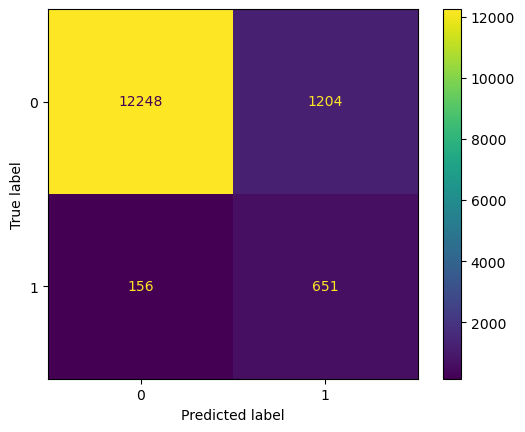

In [70]:
cm = confusion_matrix(y_test, predictions, labels=model_lgbm.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_lgbm.classes_)
disp.plot()

plt.show()

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">Теперь получим список всех треков-оригиналов из нашего датасета.

In [71]:
predictions_full = model_lgbm.predict(X)

# получаем индексы строк, где модель предсказывает 1
indices = np.where(predictions == 1)

# выгружаем все строки с индексами, где модель предсказала 1
predicted_data = df.iloc[indices]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [74]:
predicted_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1855 entries, 6 to 14277
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   track_id           1855 non-null   object        
 1   dttm               1855 non-null   datetime64[ns]
 2   title              1855 non-null   object        
 3   language           409 non-null    object        
 4   isrc               1855 non-null   object        
 5   genres             1855 non-null   object        
 6   duration           1855 non-null   int32         
 7   original_track_id  78 non-null     object        
 8   track_remake_type  1854 non-null   object        
 9   lyricId            134 non-null    object        
 10  text               134 non-null    object        
 11  year               1855 non-null   int32         
dtypes: datetime64[ns](1), int32(2), object(9)
memory usage: 173.9+ KB


<div class="alert alert-block alert-info" style="background-color:#FFFAF0;
                                                 color:black;
                                                 border-color:#DEB887;
                                                 border-radius:5px;
                                                 width:50%;
                                                 margin: auto;
                                                 text-align: left;">

<b> Вывод</b>
        <ul>
<li> AUC равен 0,86, это означает, что существует 86% вероятность того, что модель сможет отличить положительный класс от отрицательного класса. </li>
</ul>
</div>


<a id="Вывод"></a>
<div style="padding:20px;
            color:white;
            margin:10;
            font-size:170%;
            text-align:left;
            display:fill;
            border-radius:5px;
            background-color:#294B8E;
            overflow:hidden;
            font-weight:700"><span style='color:#CDA63A'>|</span> Вывод</div>

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
<br> ⚡️ Было проведено исследование, для<b> прогнозирования обнаружения каверов музыкальных треков.</b>. 
        
        
<br><b> Входные данные - исторические данные от Яндекс музыка. </b>

<br> ⚡️ Проведена предобработка данных:
    <ul>
<li> Удалены неинформативные признаки;</li>
<li> Удалены пропуски в столбце 'isrc';</li>
<li> Добавлен новый признак 'year';</li>
<li> Выбран самый ранний трек как оригинал, остальные отмечены как кавер, для груп треков с с несколькими оригиналами и каверами;</li>
<li> Столбец 'track_remake_type' переведен в бинарную систему, где ORIGINAL будет 1, а COVER будет 0;</li>
<li> Применен BERT для токенизации столбца 'title'.</li>
</ul>
        
<br> ⚡️ Обучена модель LightGBM на трех признаках: векторизованные названия треков, год релиза и длительность треков.
        
<br> ⚡️ Найдены лучшие гиперпараметры для модели через GreedSearchCV: {'learning_rate': 0.01, 'max_depth': 25, 'num_iterations': 700, 'num_leaves': 31}
        
<br> ⚡ Показано качество исследованной модели с помощью метрики ROC AUC на тестовой выборке. ROC AUC составил **0.8586** 
    
<br> ⚡️ Список предсказанных треков-оригиналов содержится в файле **predicted_data**.